<div id="image">

</div>
<div id="subject">
<CENTER>
</br>
<font size="5"></br>Chaotic systems</font></br></div>
</CENTER>
<CENTER>
<font size="3"></br>November 8, 2019</font></br></div>
</CENTER>
<CENTER>
<font size="3"></br>Supervised by : </font></br></div>
<span style="color:blue">pierre.tandeo@imt-atlantique.fr</span> and 
<span style="color:blue">lucas.drumetz@imt-atlantique.fr</span>
</CENTER>
</div>

We will use a Recurrent Neural Networks (RNN) to fit multivariate time series and to make some predictions in the future. We will use the Lorenz-63 chaotic model, also known as the strange attractor (see https://en.wikipedia.org/wiki/Lorenz_system for more details).

First, we will generate and visualize trajectories from the Lorenz-63 system. From these data, we will build training and test datasets. Then, we will adjust two models to fit the data: a classic linear autoregressive model and the specific LSTM (Long Short-Term Memory) architecture of RNN. Finally, we will compare these models in terms of prediction and simulation of new trajectories.

In [0]:
# Import libraries
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


**Generate data**

Below, we define the 3-dimensional Lorenz-63 model. This ordinary differential equation is using 3 physical parameters and we fix them to $\sigma=10$, $\rho=28$ and $\beta=8/3$. Then, we use Runge-Kutta 4-5 to integrate the model, using the *odeint()* Python function. The integration time is $0.01$ and we generate a sequence of $100$ Lorenz times.

In [0]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [0]:
from scipy.integrate import odeint

# Define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# Generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma,rho,beta))  
time = arange(0.01,T,dt)

**Visualize data**

They are 2 ways of visualizing the Lorenz-63 system. The first is to consider the system as a 3-dimensional time series: we plot each variable as a function of time. The second is the phase-space representation where we plot the relationships between variables in 3D and we track the trajectory along time.

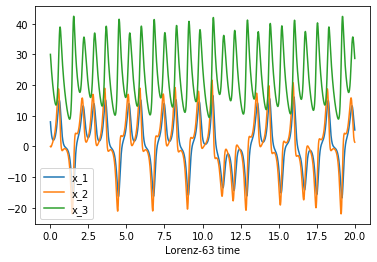

In [0]:
# Time series representation
plot(time[0:2000],x[0:2000,:])
xlabel('Lorenz-63 time')
legend(['x_1','x_2','x_3'])

Text(0.5, 0, '$x_3$')

/usr/local/lib/python3.6/dist-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


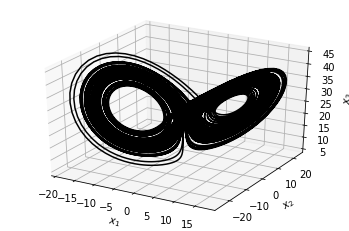

In [0]:
# Phase-space representation
from mpl_toolkits.mplot3d import Axes3D
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2], 'k')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$'); ax.set_zlabel('$x_3$')

**Create the training and test datasets**

Here, we want to predict the Lorenz-63 system at time t using the previous information at time t-0.01. It is thus a regression between the process and himself with a time delay. Here, we create a training (the first 2/3 of time series) and a test dataset (the last part).

In [0]:
def split_train_test(delay=0.01):

    T_train = int(T/dt*2/3) # size of the training set
    tau = int(delay/dt) # delay

    # Training set
    x_train = x[0:T_train,:]
    y_train = x[tau:T_train+tau,:]

    # Validation set
    x_test = x[T_train+1:-tau,]
    y_test = x[T_train+1+tau:,]
    
    return x_train, y_train, x_test, y_test

** 1:**

For the 3 components of the Lorenz-63 system, let's plot *y_train* as a function of *x_train* and comment the relationship. Then Let's see what is happening if we increase the time delay (currently set to $0.01$) between *x_train* and *y_train*.

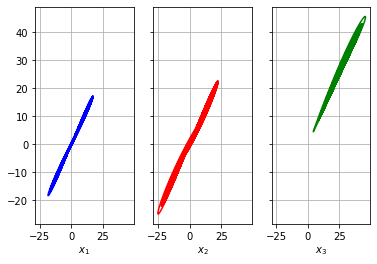

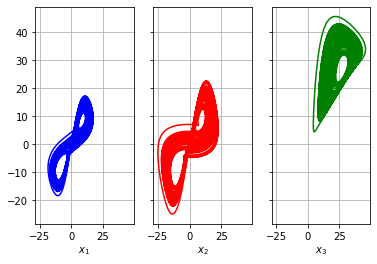

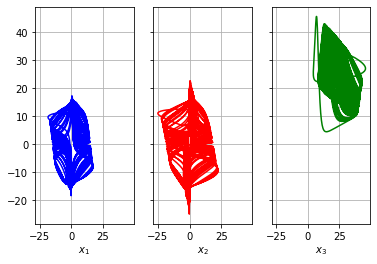

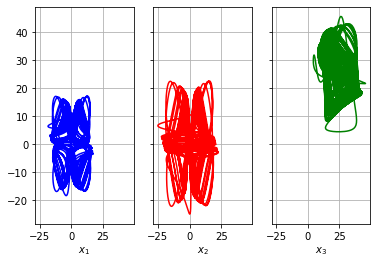

In [0]:
def subplot_Lorenz(delay=0.01):
    x_train, y_train, x_test, y_test = split_train_test(delay=delay)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='all', sharey='all')
    ax1.plot(x_train[:,0], y_train[:,0], 'b'); ax1.set_xlabel('$x_1$'); ax1.grid()
    ax2.plot(x_train[:,1], y_train[:,1], 'r'); ax2.set_xlabel('$x_2$'); ax2.grid()
    ax3.plot(x_train[:,2], y_train[:,2], 'g'); ax3.set_xlabel('$x_3$'); ax3.grid()

subplot_Lorenz(0.01)
subplot_Lorenz(0.1)
subplot_Lorenz(0.5)
subplot_Lorenz(1)

**Comment:**

The behaviour becomes more chaotic when we increase the time delay. For a small time delay there is a linear dependancy between the input and the output. This relation becomes more complex and thus more difficult to predict when we increase time delay.

** 2:**

Now let's propose a linear regression between *y_train* (at time t) and *x_train* (at time t-0.01). It corresponds to a multivariate order 1 autoregressive process noted AR(1), see more details here (https://en.wikipedia.org/wiki/Autoregressive_model). 

In [0]:
x_train, y_train, x_test, y_test = split_train_test(0.01)

In [0]:
from keras.models import Sequential
from keras.layers.core import Activation, Dense

# Build our model
model_regress1 = Sequential()

# Declare the layers
layers = [Dense(units=3, input_dim=3), Activation('linear')]

# Add the layers to the model
for layer in layers:
    model_regress1.add(layer)
    
# Model summary 
model_regress1.summary()

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWar

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile our model
model_regress1.compile(loss='mean_absolute_error', optimizer='adam')

# Fit the model
model_regress1.fit(x_train, y_train, validation_split=0.3, epochs=20)

W1108 16:05:13.676530 139778177255232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1108 16:05:13.779000 139778177255232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1108 16:05:13.820916 139778177255232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 4666 samples, validate on 2000 samples
Epoch 1/20
4666/4666 [==============================] - 0s 61us/step - loss: 21.3697 - val_loss: 19.1222
Epoch 2/20
4666/4666 [==============================] - 0s 27us/step - loss: 17.9101 - val_loss: 16.3103
Epoch 3/20
4666/4666 [==============================] - 0s 28us/step - loss: 15.1910 - val_loss: 13.8329
Epoch 4/20
4666/4666 [==============================] - 0s 28us/step - loss: 12.5953 - val_loss: 11.3834
Epoch 5/20
4666/4666 [==============================] - 0s 28us/step - loss: 10.0194 - val_loss: 8.9697
Epoch 6/20
4666/4666 [==============================] - 0s 27us/step - loss: 7.5771 - val_loss: 6.8674
Epoch 7/20
4666/4666 [==============================] - 0s 28us/step - loss: 5.6546 - val_loss: 5.3102
Epoch 8/20
4666/4666 [==============================] - 0s 28us/step - loss: 4.2797 - val_loss: 4.0281
Epoch 9/20
4666/4666 [==============================] - 0s 28us/step - loss: 3.1656 - val_loss: 2.9675
Epoch 10/20
4666

In [0]:
# Weights
model_regress1.get_weights()

[array([[ 8.99154723e-01, -5.30257076e-02,  1.45558715e-02],
        [ 1.00032471e-01,  1.04755437e+00,  6.79639960e-03],
        [ 3.02158180e-04, -2.91837994e-02,  9.34708357e-01]], dtype=float32),
 array([0.0012993, 0.7664157, 1.2550838], dtype=float32)]

**Comment:**

The weight matrix follow the behaviour of a diagonal matrix. This means that to predict the next value of each one of the components the model relies the most over the value of that same component at the actual time. This just reflects what we previously observed in the graph with delay equal to 0.01. There is a strong linear dependency with this delay. 

**3:**

Now, let's use a RNN architecture to learn the variations of the time series. 

Note that to use RNN in Keras, we need to change the 2D shapes of *x_train* and *x_test* (originally 6666x3 and 3331x3) into 3D shapes (respectively 6666x3x1 and 3331x3x1): this is done in the cell below.

In [0]:
# Reshape x_train and x_test for LSTM
x_train_LSTM = reshape(x_train, (shape(x_train)[0], shape(x_train)[1], 1))
x_test_LSTM = reshape(x_test, (shape(x_test)[0], shape(x_test)[1], 1))
print(shape(x_train_LSTM))
print(shape(x_test_LSTM))

(6666, 3, 1)
(3331, 3, 1)


In [0]:
from keras.layers import LSTM

model_regress2 = Sequential()
model_regress2.add(LSTM(4, activation='linear', recurrent_activation='sigmoid', input_shape=(3,1)))
model_regress2.add(Dense(3, activation='linear'))
model_regress2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 15        
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile our model
model_regress2.compile(loss='mean_absolute_error', optimizer='adam')

# Fit the model
model_regress2.fit(x_train_LSTM, y_train, validation_split=0.3, epochs=100)

Train on 4666 samples, validate on 2000 samples
Epoch 1/100
4666/4666 [==============================] - 1s 194us/step - loss: 9.8589 - val_loss: 6.6487
Epoch 2/100
4666/4666 [==============================] - 0s 92us/step - loss: 4.3089 - val_loss: 3.1736
Epoch 3/100
4666/4666 [==============================] - 0s 93us/step - loss: 2.3186 - val_loss: 1.8615
Epoch 4/100
4666/4666 [==============================] - 0s 96us/step - loss: 1.4784 - val_loss: 1.3741
Epoch 5/100
4666/4666 [==============================] - 0s 97us/step - loss: 1.2395 - val_loss: 1.2225
Epoch 6/100
4666/4666 [==============================] - 0s 100us/step - loss: 1.1389 - val_loss: 1.1448
Epoch 7/100
4666/4666 [==============================] - 0s 99us/step - loss: 1.0903 - val_loss: 1.1068
Epoch 8/100
4666/4666 [==============================] - 0s 106us/step - loss: 1.0619 - val_loss: 1.0775
Epoch 9/100
4666/4666 [==============================] - 0s 103us/step - loss: 1.0272 - val_loss: 1.0563
Epoch 10/100

4666/4666 [==============================] - 0s 97us/step - loss: 0.0997 - val_loss: 0.0932
Epoch 79/100
4666/4666 [==============================] - 0s 97us/step - loss: 0.1013 - val_loss: 0.0980
Epoch 80/100
4666/4666 [==============================] - 0s 97us/step - loss: 0.1029 - val_loss: 0.0965
Epoch 81/100
4666/4666 [==============================] - 0s 98us/step - loss: 0.1041 - val_loss: 0.0985
Epoch 82/100
4666/4666 [==============================] - 0s 98us/step - loss: 0.0986 - val_loss: 0.0954
Epoch 83/100
4666/4666 [==============================] - 0s 99us/step - loss: 0.0955 - val_loss: 0.0910
Epoch 84/100
4666/4666 [==============================] - 0s 97us/step - loss: 0.0959 - val_loss: 0.0881
Epoch 85/100
4666/4666 [==============================] - 0s 97us/step - loss: 0.0947 - val_loss: 0.0892
Epoch 86/100
4666/4666 [==============================] - 0s 98us/step - loss: 0.0930 - val_loss: 0.0852
Epoch 87/100
4666/4666 [==============================] - 0s 98us/st

In [0]:
# Weights
model_regress2.get_weights()

[array([[ 0.31674263, -0.05493036,  0.14121138, -0.26717237,  0.123845  ,
         -0.03306795,  0.04813772,  0.0341193 , -0.34938526, -0.4137519 ,
          0.410609  , -0.6042622 ,  0.11848308, -0.04423302,  0.16212152,
          0.04315858]], dtype=float32),
 array([[-1.7097434 , -0.23281908, -0.3084898 ,  0.12812535,  0.0089145 ,
          0.03134568, -1.4291985 , -0.87057817,  0.11362532,  0.79463726,
          0.65269375, -1.8108047 , -0.5322487 , -0.50696146,  0.43889305,
          2.0470197 ],
        [ 0.6549246 , -0.03958163,  0.42165098, -0.3762196 ,  0.7039132 ,
         -0.09323847, -0.13499099,  0.9260965 , -0.6070562 ,  0.76119167,
         -0.8623661 , -0.16191576,  0.22504   , -0.23007117, -0.5919635 ,
         -0.21533717],
        [ 1.1192418 , -0.08293951,  0.02898303, -0.82624143, -0.51382476,
          0.46301767,  0.80744493, -0.5976293 , -0.05529983, -0.69640803,
         -0.53052527,  0.35897553,  0.31668416,  0.03940985, -0.3554874 ,
         -0.02921765],
   

**Comment:**

The last two matrices are the one for the dense layers. The first one  stores the input weights (and biases) of the lstm. The second stores the weights  (and biases) of the hidden states ( a weigth for every hidden state).

**4:**

To Compare the predictions of the linear regression AR(1) and the LSTM architecture on the test dataset. we will Compute the root mean squared errors (for each component) between the predicted values and the truth. and plot the histograms of the residuals (difference between prediction and truth) for the 2 models.

In [0]:
from sklearn.metrics import mean_squared_error

y_pred1 = model_regress1.predict(x_test)
y_pred2 = model_regress2.predict(x_test_LSTM)

rmse1 = sqrt(mean_squared_error(y_test, y_pred1))
rmse2 = sqrt(mean_squared_error(y_test, y_pred2))

print(rmse1, rmse2)

0.6756360128056829 0.13276486271539598


In [0]:
bins = 25 
dif1 = y_test-y_pred1
dif2 = y_test-y_pred2

Text(0.5, 1.0, 'LSTM - $x_1$')

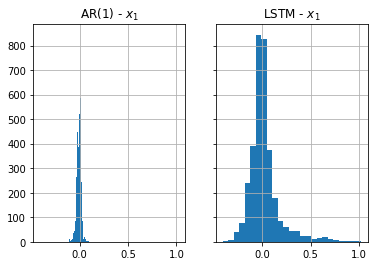

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all')
ax1.hist(dif1[:,0], bins=bins); ax1.grid(); ax1.set_title('AR(1) - $x_1$')
ax2.hist(dif2[:,0], bins=bins); ax2.grid(); ax2.set_title('LSTM - $x_1$')

Text(0.5, 1.0, 'LSTM- $x_2$')

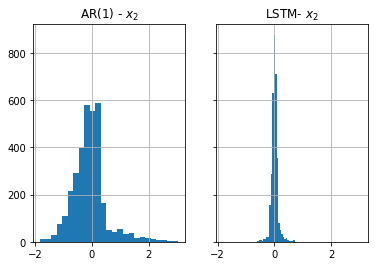

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all')
ax1.hist(dif1[:,1], bins=bins); ax1.grid(); ax1.set_title('AR(1) - $x_2$')
ax2.hist(dif2[:,1], bins=bins); ax2.grid(); ax2.set_title('LSTM- $x_2$')

Text(0.5, 1.0, 'LSTM - $x_3$')

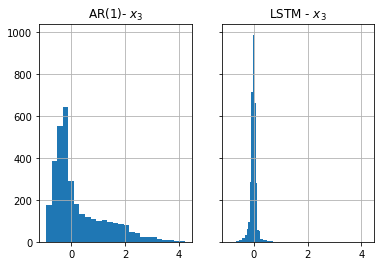

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all')
ax1.hist(dif1[:,2], bins=bins); ax1.grid(); ax1.set_title('AR(1)- $x_3$')
ax2.hist(dif2[:,2], bins=bins); ax2.grid(); ax2.set_title('LSTM - $x_3$')

**Comment:**

Our LSTM model behaves in a better way for the variables $x_2$ and $x_3$ and for $x_1$ the prediction is better with the AR model. This given the way the variables are constructed, $x_1$ has a more linear behavior. However, for the AR model it is difficult to properly modelate the behavior of the variables with more complex dependencies.

**5:**

Now, starting from an initial condition (for instance the last value of *y_test*), let's use the AR(1) model and the RNN to simulate new data (for instance a sequence of 1500 time steps) and see if  the resulting   look like the original ones.
 

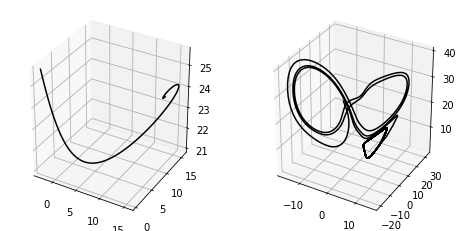

In [0]:
n = 1000

seq1 = np.zeros((n,3))
seq1[0,:] = y_test[-1]
seq2 = np.copy(seq1)

for i in range(1,n):
    seq1[i] = model_regress1.predict(np.reshape(seq1[i-1,:],(-1,3)))
    seq2[i] = model_regress2.predict(np.reshape(seq2[i-1,:],(-1,3,1)))

fig = plt.figure(figsize=plt.figaspect(0.5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.gca(projection='3d')
ax1.plot(seq1[:,0], seq1[:,1], seq1[:,2], 'k')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2 = fig.gca(projection='3d')
ax2.plot(seq2[:,0], seq2[:,1], seq2[:,2], 'k')

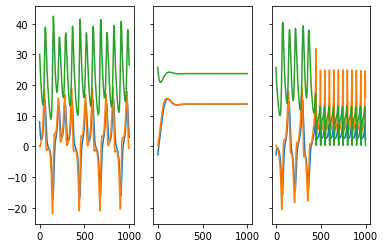

In [0]:
# Time series representation
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='all', sharey='all')
ax1.plot(x[:n])
ax2.plot(seq1)
ax3.plot(seq2)

**Comment:**

The behavior of the predicted values actually changed strongly depending on the iteration. The linear model was capable of doing some spirals but never able to change the direction to the other side. The second model was not strong at the begining, but after increasing the amount of units from 3 to 4 and specifying the __recurrent_activation__ to "sigmoid", it was able to follow the expected trajectory.

We can see in the plot above that the first model was stucked after 200 iterations without having a good response. The LSTM model was capable of recreating the behavior of the original graph with a good quality before the 500 iteration. However, the models seem to converge to a particular behavior after some time.

Normally, even with the linear recurrent_activation the LSTM should behave better or at least the same as the AR model, but since it has more parameters, the optimization process is more difficult.

**6:**

Let's try  to increase the quality of the prediction with a now LSTM architecture. To do this we will transform the input of the RNN, taking into account more time lags (for instance $t-1$, $t-2$, $t-3$) to explain the Lorenz-63 system at time $t$.

In [0]:
look_back = 3

def split_train_test_look_back():
    
    dim = list(x.shape)
    dim[0] -= look_back
    
    x_LSTM = x[:-look_back].reshape((dim[0], dim[1], -1))
    
    for i in range(1, look_back):
        aux = x[i:-look_back+i].reshape((dim[0], dim[1], -1))
        x_LSTM = np.concatenate((x_LSTM, aux), axis=1).reshape(dim[0], -1, 1)
    
    y_LSTM = x[look_back:]
    
    T_train = int(y_LSTM.shape[0]*2/3) # size of the training set

    # Training set
    x_train_LSTM = x_LSTM[:T_train]
    y_train_LSTM = y_LSTM[:T_train]

    # Validation set
    x_test_LSTM = x_LSTM[T_train:]
    y_test_LSTM = y_LSTM[T_train:]
    
    return x_train_LSTM, y_train_LSTM, x_test_LSTM, y_test_LSTM

x_train_LSTM, y_train_LSTM, x_test_LSTM, y_test_LSTM = split_train_test_look_back()

In [0]:
x_train_LSTM.shape

(6664, 9, 1)

In [0]:
model_regress3 = Sequential()
model_regress3.add(LSTM(10, activation='linear', recurrent_activation='sigmoid', input_shape=(3*look_back,1)))
model_regress3.add(Dense(3, activation='linear'))
model_regress3.summary()

# Compile our model
model_regress3.compile(loss='mean_absolute_error', optimizer='adam')

# Fit the model
model_regress3.fit(x_train_LSTM, y_train_LSTM, validation_split=0.3, epochs=100)

# Predict
y_pred3 = model_regress3.predict(x_test_LSTM)

rmse3 = sqrt(mean_squared_error(y_test_LSTM, y_pred3))

print(rmse3)

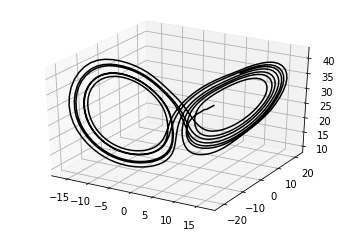

In [0]:
n = 1000

seq3 = np.zeros((n,3))
#seq3[:look_back,:] = y_test_LSTM[-look_back:]
seq3[:look_back,:] = x[:3,:]

for i in range(look_back,n):
    seq3[i] = model_regress3.predict(np.reshape(seq3[i-look_back:i],(-1,3*look_back,1)))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(seq3[:,0], seq3[:,1], seq3[:,2], 'k')

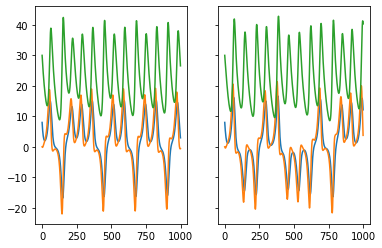

In [0]:
# Time series representation
f, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all')
ax1.plot(x[:n])
ax2.plot(seq3)

__Note__: When the prediction is made over the same signal there is a point where the signal converges to a particular behavior or value. Even as we use more points in time to make a better prediction the result is, at the end, the same. However, in this particular case there was a softer transition which means that the behavior we try to recreate is going to last longer.

The initial values taken from the network can define how fast a 